# **Предстоит решить задачу классификации**
 На вход подается полнослайдовое гистологическое изображение размером 224x224 пикселя, 8-битные ргб

 Цель: Сделать свою умную модель, которая на вход получает изображение, а на выходе получает одну из девяти меток соответствующий классам.
 Получается вектор с 9-ти значений с вероятностями. [ADI, BACK, DEB, LYM, MUC, MUS, NORM, STR, TUM]

Даются 2 набора данных:
1) Обучающие - train (2000 патчей каждого класса -> 18000 патчей)
2) Для тестирование - test (500 патчей каждого класса -> 4500 патчей)


Они сбалансированны (В реальности такого не может быть.

Также для нашего удобства даются маленькие поднаборы
* train_small (800 патчей каждого класса -> 7200 патчей)
* train_tiny  (100 патчей каждого класса -> 900 патчей)

И аналогичные
* test_small (200 патчей каждого класса -> 1800 патчей)
* test_tiny  (10 патчей каждого класса -> 90 патчей)

 Для ОТЛАДОЧНЫХ целей. (Для удобства)

 Т.к. 18 тыс изображений загрузить сложно за раз, то для отладки нашего пайплайна, для того, чтобы понять, он там вообще запускается ли или падает ли. Мы будем использовать train_tiny набор. Для проверки уже того, что он обучается/не обучается - будем использовать train_small набор. И когда всё отладили запускаем большой (основной) набор.


 Также предоставлен шаблонный код с некоторым шаблонными решением (в нём стандартные функциии работы с изображением и ML)

 Замечание! После завершения задачи, будет проводиться тестовый набор на test2 - 2700 патчей и test3 - на 7189 патчей (близок к реальности), на этом формируется итоговая оценка.

 Нет ограничения на методах решения задачи. Рекомендовано не использоавть как в шаблоне свёрточную нейронку или трансформеры и просто обучить на этих данных, а использовали что то более интересное. Можно использовать как классические методы ML, так и современные нейронные сети. (Например текстуры + классические методы)  

Далее требуется, завести аккаунт в github-е и прикрепить:
* ноутбук Google Colab c решением;
* pdf распечатка ноутбука с выполненными ячейками, результатами, графиками и т.п.;
* README.md с кратким описанием результатов и списком выполненных пунктов;

(!) Все реализованные опции должны быть помечены в коде метками #LBL1, #LBL2, и т.д. с текстовой расшифровкой в README.md;

Любые дополнительные используемые файлы и директории (например, директория с изображениями, полученными в результате тестирования) должны быть также упомянуты в README.md;

**Реализованная модель должна иметь работающую реализацию метода load(), автоматически
загружающую веса обученной модели из облачного хранилища;**

То есть мы обучаем модельку в гугл колабе. Какие то коэффициенты обучили, это может быть коэффициенты для классических моделей обучения (гиперпараметры), это может быть просто веса глубокого обучения. И мы обычно их сохраняем на гугл-драйв и делаем специальную ссылку и реализуем метод-load() так, чтобы потом любой другой человек мог запустить этот ноутбук, вызвать функцию load() и наша моделька автоматически скачивает веса из сети и с ней спокойно работает. Это то как А. Хвостиков сможет запустить мой ноутбук.

!!! ДЕДЛАЙН !!! 1-ДЕКАБРЯ !!!   


In [90]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [64]:
# Примонтирование гуглдрайва к текущему проекту (к нашему окружению)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [65]:
# Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:
EVALUATE_ONLY = False # Константа отвечает за то, запускать в режиме inference или в режиме обучения
TEST_ON_LARGE_DATASET = True # Запускать на большом dataset-e или нет
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM') # классы от 0 до 8
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

#!!! Нужно обратить внимение на ссылки на датасеты
# При реализации метода-load() нужно будет сделать +- тоже самое
# То есть у нас ветвь внутри кода, будут забиты такие же ссылки,
# и с помощью пакета gdown будем подтягивать веса сети из облачного хранилищу



In [66]:
# Стандартные библиотеки Python
from pathlib import Path
from typing import List
import os
from time import sleep

# Научные/Числовые вычисления и работа с данными
import numpy as np
import joblib

# Работа с изображениями и визуализацией
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display

# Машинное обучение и метрики (Scikit-learn)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# Глубокое обучение (PyTorch) и обработка изображений
import torch
import torchvision.models as models
import torchvision.transforms as T

# Вспомогательные утилиты
from tqdm.notebook import tqdm
import gdown

---
### Класс Dataset
---

In [67]:
# Класс Dataset
# Предназначен для работы с наборами данных, обеспечивает чтение изображений
# и соответствующих меток, а также формирование пакетов (батчей).

# Данный класс скачивает dataset по имени, то есть мы даём ему имя train train_small test...
# Он автоматический обращается к словарику ВЫШЕ, вытягивает ссылку и скачивает NPZ архив его открывает
# и там находится изображение и метки для него
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
# У нас есть готовые метки, мы можем обратиться к i-му изображению.

        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
# Либо мы можем получить генератор изображении

        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
# Либо мы можем обратиться к случайным изображениям, и взять случайное изображение с лейблом
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
# Или сформировать батч или пакет тоже случайных изобраэений с лэйблами
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

# УДОБНАЯ ШТУКА, ЧТОБЫ РАБОТАТЬ С ИЗОБРАЖЕНИЯМИ, тут происходит внутри чтение и преобразование к numpy виду

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 169MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 5.
Label code corresponds to MUS class.


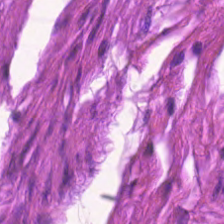

In [68]:
# Пример использвания класса Dataset
# Загрузим обучающий набор данных, получим произвольное изображение с меткой.
# После чего визуализируем изображение, выведем метку.
# В будущем, этот кусок кода можно закомментировать или убрать.

d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
# Берём случайное изображение и соответствующую метку
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics
---

In [69]:
# Для того, чтобы оценивать точность решения, используются класс метрикс, в котором реализована точность и сбалансированная точность

class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model
---

In [88]:
# КЛАССЫ МОДЕЛЬ - ОСНОВНОЙ КЛАСС, который нужно мне реализовать
# Так как мы говорим, о том, что у меня есть какой то условно движковый независимое решение

# У НАС есть внешее обёртка модель, её НЕЛЬЗЯ изменять внешними методам, они будут использоваться для тестирования в том числе для хвостикова Pypeline-а
# ПОЭТОМУ всё что нам надо сделать - это реализовать вот эти методы внутри


# Разрешено брать ПРЕД-обученные модели
class Model:
    """
    Классическая ML-модель классификации.
    Признаки извлекаются замороженной EfficientNetB0.
    Классификатор — классический линейный SVM).
    """

    def __init__(self,use_gpu: bool | None = None,feature_cache_dir: str = '/content/drive/MyDrive/model_cache/', model_save_dir: str = '/content/drive/MyDrive/'):

        # выбор устройства
        if use_gpu is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device("cuda" if use_gpu else "cpu")

        # директории для моделей и кэша
        os.makedirs(feature_cache_dir, exist_ok=True)
        os.makedirs(model_save_dir, exist_ok=True)
        self.feature_cache_dir = feature_cache_dir
        self.model_save_dir = model_save_dir

        # подгружаем EfficientNetB0 без классификатора
        self.cnn = models.efficientnet_b0(weights="IMAGENET1K_V1")
        self.cnn.classifier = torch.nn.Identity()  #  выход 1280 признаков
        self.cnn.eval()
        self.cnn.to(self.device)

        # преобразования
        self.tr = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

        # классический линейный SVM
        self.clf = SVC(kernel="linear")

        self._is_trained = False
        self._last_train_meta = {}
        self._feature_shape = None

    # извлечение признаков EfficientNet
    def _extract_feature(self, img: np.ndarray):
        pil = Image.fromarray(img)
        x = self.tr(pil).unsqueeze(0).to(self.device)
        with torch.no_grad():
            feat = self.cnn(x).cpu().numpy().reshape(-1)
        return feat

    def extract_feature(self, img):
        return self._extract_feature(img)

    # путь к файлу кэша
    def _cache_path(self, dataset_name: str):
        safe = dataset_name.replace('/', '_')
        return os.path.join(self.feature_cache_dir, f'features_{safe}.npz')

    # кэширование признаков
    def cache_features_if_needed(self, dataset, dataset_name, force_recompute=False):
        path = self._cache_path(dataset_name)

        if os.path.exists(path) and not force_recompute:
            print("Загружаю признаки из:", path)
            d = np.load(path)
            return d['X'], d['y']

        print("Извлекаю признаки EfficientNetB0…")
        X, y = [], []
        for i in tqdm(range(dataset.n_files)):
            img, label = dataset.image_with_label(i)
            X.append(self.extract_feature(img))
            y.append(label)

        X, y = np.array(X), np.array(y)
        np.savez_compressed(path, X=X, y=y)
        print("Кэш сохранён:", path)

        return X, y

    #                    ТРЕНИРОВКА
    def train(self, dataset, dataset_name='train', val_fraction=0.1, do_grid_search=True,
              grid_params=None, use_crossval=False, cv_folds=3, autosave_best_name='best_svm', save_plots=True):

        # загружаем признаки
        X, y = self.cache_features_if_needed(dataset, dataset_name)

        # делим train/val
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=val_fraction, stratify=y, random_state=42
        )

        # GridSearchCV (автоподбор гиперпараметров)
        if do_grid_search:
            if grid_params is None:
                grid_params = {'C': [0.01, 0.1, 1, 5, 10]}

            print("Запуск GridSearchCV:", grid_params)

            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42) \
                if use_crossval else 3

            search = GridSearchCV(
                SVC(kernel="linear"),
                grid_params,
                scoring='balanced_accuracy',
                cv=cv,
                n_jobs=-1,
                verbose=1
            )

            search.fit(X_train, y_train)
            print("Лучшие параметры:", search.best_params_)

            self.clf = search.best_estimator_
        else:
            self.clf.fit(X_train, y_train)

        # проверка на валидации
        preds = self.clf.predict(X_val)
        acc = accuracy_score(y_val, preds)
        bal = balanced_accuracy_score(y_val, preds)
        print(f"Валидация: ACC={acc:.4f}, BAL_ACC={bal:.4f}")

        self._last_train_meta = {'val_acc': acc, 'val_bal_acc': bal}

        # автосохранение
        self.save(autosave_best_name)
        self._is_trained = True
        self._feature_shape = X.shape[1]

        return True

    #              ТЕСТИРОВАНИЕ / ПРЕДСКАЗАНИЕ

    def test_on_image(self, img):
        if not self._is_trained:
            raise RuntimeError("Модель не обучена!")
        feat = self.extract_feature(img).reshape(1, -1)
        return int(self.clf.predict(feat)[0])


  # Метод test_on_dataset (самый главный метод который хвостиков будет вызывать во время решений)
  # Придаём dataset и есть еще доп параметр  limit=None - это слайсинг, ограничение сколько мы обьектов из датасета берём, для того, чтобы просто запустить и не терять времени можно делать там 0.1 и у нас только 10% тестовой выборки тестируется.
    def test_on_dataset(self, dataset, limit=None):
        """
        Прогон датасета через модель.
        limit – ограничение количества элементов для теста (для быстрой отладки)
        """
        preds = []
        n = dataset.n_files if limit is None else min(limit, dataset.n_files)

        for img in tqdm(dataset.images_seq(n=n), total=n):
            preds.append(self.test_on_image(img))

        return preds


    #            СОХРАНЕНИЕ / ЗАГРУЗКА


    # МЕТОД СОХРАНЕНИЯ, то есть мы должны написать метод сохр модельки, куда на вход подаёте имя и она куда то в наш PROJECT_DIR
    # в PROJECT_DIR в наш рабочий проект сохраняет ВЕСА.
    def save(self, name):
        path = os.path.join(self.model_save_dir, f"{name}.joblib")
        joblib.dump({'clf': self.clf, 'meta': self._last_train_meta}, path)
        print("Модель сохранена:", path)


    MODEL_URLS = {
        "best": "https://drive.google.com/uc?id=1CmhM9t-DPL36YPAU56ZJD6IgtkVi8RWy"
    }
    def load(self, name, url=None):
        path = os.path.join(self.model_save_dir, f"{name}.joblib")

        if not os.path.exists(path):
            if url is None:
                url = self.MODEL_URLS.get(name)

            if url is None:
                raise FileNotFoundError("Нет локального файла и URL для загрузки.")

            print(f"Скачиваю: {url}")
            gdown.download(url, path, fuzzy=True, quiet=True)

        data = joblib.load(path)
        self.clf = data["clf"]
        self._is_trained = True
        print("Модель загружена:", path)

    # def load(self, name):

      # # ВОТ ТУТ НАМ НУЖНО фактический сделать словарик, реализовать его, так, чтобы наша модель автоматисечкий стягивала ВЕСА
      #   path = os.path.join(self.model_save_dir, f"{name}.joblib")
      #   data = joblib.load(path)
      #   self.clf = data['clf']
      #   self._last_train_meta = data.get('meta', {})
      #   self._is_trained = True
      #   #  И далее их не просто вот РАСПЕЧАТАТЬ (ниже), а засунуть внутрь ядра нашей модельки
      #   print("Модель загружена:", path)

    #                 МАТРИЦА ОШИБОК

    def save_confusion_matrix(self, gt, preds, classes=None, name="conf_matrix"):
        cm = confusion_matrix(gt, preds)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=classes, yticklabels=classes)
        plt.xlabel("Предсказание")
        plt.ylabel("Истинный класс")
        plt.title("Матрица ошибок")
        plt.show()

        return cm


# как итог вся модель это энтропия взаимодейсвтия с внешним миром с тестовой средой и он должен быть модифицирован
# Внутри используем разные подходы, поэтому внутри мы можем делать вс1 что захотим

In [89]:
d_train = Dataset('train')
d_test  = Dataset('test')

m = Model() # Создаём модель

history = m.train( # Обучаем модель
    d_train,
    dataset_name='train',
    val_fraction=0.1,
    do_grid_search=True,
    grid_params={'C': [0.01, 0.1, 1]},
    autosave_best_name='best'
)


preds = m.test_on_dataset(d_test) # Предсказываем на test
Metrics.print_all(d_test.labels, preds, info="CNN-features + SVM")# Считаем метрики

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:41<00:00, 50.7MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:11<00:00, 46.3MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.
Загружаю признаки из: /content/drive/MyDrive/model_cache/features_train.npz
Запуск GridSearchCV: {'C': [0.01, 0.1, 1]}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Лучшие параметры: {'C': 0.01}
Валидация: ACC=0.9556, BAL_ACC=0.9556
Модель сохранена: /content/drive/MyDrive/best.joblib


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for CNN-features + SVM:
	 accuracy 0.9080:
	 balanced accuracy 0.9080:


In [83]:

# ПРОВЕРКА ПРООООООООООООООООООВЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕЕРКАААААААААААААААААААААААААА

d_test2 = Dataset("test_small")
d_test3 = Dataset("test")


m = Model()
m.load("best")

pred2 = m.test_on_dataset(d_test2)
Metrics.print_all(d_test2.labels, pred2, "test_small")

pred3 = m.test_on_dataset(d_test3)
Metrics.print_all(d_test3.labels, pred3, "test")


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:02<00:00, 89.6MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:11<00:00, 44.6MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.
Модель загружена: /content/drive/MyDrive/best.joblib


  0%|          | 0/1800 [00:00<?, ?it/s]

metrics for test_small:
	 accuracy 0.9044:
	 balanced accuracy 0.9044:


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9080:
	 balanced accuracy 0.9080:


In [86]:
# МАТРИЦА ОШИБОК - ДОП ЗАДАНИЕ

In [87]:
# получаем предсказания
preds = m.test_on_dataset(d_test)

# выводим матрицу ошибок
m.save_confusion_matrix(
    gt=d_test.labels,
    preds=preds,
    classes=TISSUE_CLASSES
)

  0%|          | 0/4500 [00:00<?, ?it/s]

Матрица ошибок сохранена: /content/drive/MyDrive/conf_matrix.png


array([[489,   3,   0,   0,   5,   1,   1,   0,   1],
       [  3, 495,   2,   0,   0,   0,   0,   0,   0],
       [  0,   1, 474,   2,   1,   8,   0,   7,   7],
       [  0,   0,  12, 484,   0,   0,   1,   0,   3],
       [  0,   0,   7,   0, 438,  17,  14,  16,   8],
       [  0,   0,   8,   0,   3, 429,   3,  52,   5],
       [  1,   0,   2,   5,  19,   5, 435,   2,  31],
       [  0,   0,  18,   0,   6,  19,   7, 445,   5],
       [  0,   0,  16,   4,  14,  10,  47,  12, 397]])